# Segmentation des Images de la Microscopie Électronique

L’IA permet de simplifier et d’accélérer le travail des équipes d’imagerie, aujourd’hui majoritairement sur les 
étapes précliniques, en facilitant la lecture des images. Le CHRU a donc besoin d'un outil IA pour segmenter un 
tel type d'images. Il vous demande de l'aide pour cet objectif.

### Contexte du projet

L’IA est aujourd’hui omniprésente dans la littérature scientifique de l’imagerie médicale, d’autant plus depuis 
le développement de nouveaux algorithmes appelés réseaux de neurones convolutifs.

En effet, à ce jour, l’IA est très utile dans le domaine de l’imagerie, sur deux volets : la classification des 
images et la segmentation des organes. Les algorithmes pour classifier les images peuvent permettre d’aider au 
diagnostic en classant une image dans une catégorie particulière de pathologie. Les algorithmes pour segmenter 
les images sont couramment utilisés sur tous les types d’imagerie et en routine au CHRU. C’est ainsi que l’IA 
permet un gain de temps aux praticiens à la fois pour le diagnostic ou lors d’interventions. Elle présente aussi 
l’avantage de contourner certains biais liés à l’interprétation de l’opérateur.

### Les données.

Les données proviennent du défi ISBI 2012 pour la segmentation des structures neuronales dans l'empilement 
de microscopie électronique. 

Les données de formation sont un ensemble de 30 sections d'une section série de données de microscopie 
électronique à transmission (ssTEM) du cordon nerveux ventral de la larve du premier stade de la drosophile.
Le microcube mesure 2 x 2 x 1,5 microns environ, avec une résolution de 4 x 4 x 50 nm / pixel. Chaque image a 512x512 pixels.

Les étiquettes binaires correspondantes (répertoire label) sont fournies en blanc pour les pixels des objets segmentés 
et en noir pour le reste des pixels (qui correspondent principalement à des membranes).

L'objectif étant de confronter nos images train avec les masks (labels) afin de pouvoir effectuer notre modèle 
de prédictions.


Les données sont disponibles au format TIF ou TIFF (Tagged Image File Format) qui est un format de fichier 
graphique bitmap (raster). 

**Caractéristiques du format TIF**

Le format TIFF est un ancien format graphique, permettant de stocker des images bitmap (raster) de taille importante (plus de 4 Go compressées), sans perdition de qualité et indépendamment des plates formes ou des périphériques utilisés (Device-Independant Bitmap, noté DIB).

Le format TIFF permet de stocker des images en noir et blanc, en couleurs réelles (True color, jusqu'à 32 bits par pixels) ainsi que des images indexées, faisant usage d'une palette de couleurs. 
Ce format peut être utilisé pour des images médicales.
                                                                                   
                                                                                


Nous utiliserons google colab pour le lancement de notre modèle.

##  transformation des images .tiff en .png

### ouverture du notebook sur google colab

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


### ouverture du jeu de données sur google colab

In [ ]:
#zip_path = '/content/drive/MyDrive/segmentation/data.zip'

#!cp "{zip_path}" .

#!unzip -q data.zip

# Remove .zip file after you unzip it
#!rm data.zip

# Make sure it's there
#!ls

data  drive  sample_data


In [29]:
#on se positionne sur le répertoire de travail
#ls
#%cd "/content/drive/MyDrive/segmentation/"


/content/drive/MyDrive/segmentation


### Importation des bibliothèques

In [12]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

import skimage
from skimage import io, util, filters, transform


In [12]:
#for photo in os.listdir(label_path):
#    if re.search('.tif$', photo):
#        outfile = os.path.splitext(os.path.join(newlabel_path, photo))[0] + ".png"
#        if not(os.path.isfile(outfile)):
#            im = Image.open(os.path.join(label_path, photo))
#            im.thumbnail(im.size)
#            im.save(outfile, "PNG", quality=100)

In [13]:
 
#transformation des fichiers tif et png du répertoire train

Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])


def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255 # normalisation des images
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #pour un pixel de l'image, on trouve la classe dans le masque et la convertit en vecteur à chaud
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)



def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    peut générer une image et un masque en même temps
    utilisez la même graine pour image_datagen et mask_datagen pour vous assurer que la transformation de l'image et du masque est la même
    si vous souhaitez visualiser les résultats du générateur, définissez save_to_dir = "votre chemin"

    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,# taille des lots de données
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,#tuple d'entiers, par défaut: (256, 256). Les dimensions auxquelles toutes les images trouvées seront redimensionnées.
        batch_size = batch_size,
        save_to_dir = save_to_dir,#Cela vous permet de spécifier de manière optimale un répertoire dans lequel enregistrer les images augmentées en cours de génération (utile pour visualiser ce que vous faites).
        save_prefix  = mask_save_prefix,#Préfixe à utiliser pour les noms de fichiers des images enregistrées (pertinent uniquement si save_to_direst défini).
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)



def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img


def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr


def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255



def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

### Visualisation de nos données train (jeu d'apprentissage) 

Nous souhaitons établir ici une comparaison entre nos images et nos masks afin de pouvoir par la suite établir 
un modèle de prédiction sur nos images de test.
Nous allons donc dans un premier temps visualiser nos images ainsi les masks associés sur le jeu d'entraînement.

![imagetrain0](imagetrain0.png)

![masktrain0](masktrain0.png)

Nous avons ici l'image 0 avec son mask associé.

### Segmentation gràce au réseau neuronal U Net

Pour réaliser la segmentation de nos images microscopiques, nous utiliserons U-Net qui est un réseau neuronal 
entièrement convolutif avec une structure codeur-décodeur conçu pour la segmentation d'images sementiques sur 
des images biomédicales.
C'est une architecture de méta-réseau très efficace qui a été adaptée pour incorporer d'autres conceptions 
d'architecture de réseau neuronal convolutif.



L'architecture U-net est synonyme d'architecture encodeur-décodeur. Il s'agit essentiellement d'un cadre 
d'apprentissage en profondeur basé sur les FCN; il comprend deux parties:

* Un chemin contractuel similaire à un encodeur, pour capturer le contexte via une carte de caractéristiques compacte.
* Un chemin d'extension symétrique similaire à un décodeur, qui permet une localisation précise. Cette étape est 
effectuée pour conserver les informations de limite (informations spatiales) malgré le sous-échantillonnage et 
le regroupement maximal effectués dans l'étage du codeur.

![architectureUnet](architectureUnet.png)

**Architecture U-net (exemple pour 32x32 pixels dans la résolution la plus basse).**


Chaque boîte bleue correspond à une carte des caractéristiques multicanaux. Le nombre de canaux est indiqué en 
haut de la boîte. La taille x-y est fournie sur le bord inférieur gauche de la boîte. Les boîtes blanches 
représentent les cartes d'entités copiées. Les flèches indiquent les différentes opérations



**Avantages de l'utilisation d'U-Net**

    1. Efficace en termes de calcul
    2. Entraînable avec un petit ensemble de données
    3. Formé de bout en bout
    4. Préférable pour les applications biomédicales

Chaque pixel d'une image est doté d'une étiquette de classe. Vous obtenez des cartes de segmentation, qui 
ressemblent à celle de la figure ci dessus. Auparavant, les chercheurs biomédicaux suivaient deux approches:

    1. Classer l'image dans son ensemble (maligne ou bénigne).
    2. Diviser les images en patchs et les classer.

En raison de l'augmentation de la taille de l'ensemble de données, la correction était certainement meilleure 
qu'une classification d'image entière, cependant, il y avait quelques inconvénients liés à la même chose. 
De plus petits pas ou des correctifs avec beaucoup de chevauchement sont à la fois intensifs en calcul et 
entraînent des informations redondantes (répétitives). De plus, un bon compromis entre les informations 
contextuelles et la localisation est vital. Les petits correctifs entraînent une perte d'informations 
contextuelles tandis que les gros correctifs altèrent les résultats de la localisation. 
Enfin, les correctifs qui ne se chevauchent pas entraînent une perte d'informations de contexte. 
Sur la base d'observations antérieures, une architecture codeur-décodeur produit des valeurs d'intersection 
sur union (IoU) beaucoup plus élevées que l'alimentation de chaque pixel à un CNN pour la classification.

### Augmentation des données



Les données pour la formation ne sont pas suffisantes pour alimenter un réseau de neurones d'apprentissage en 
profondeur. On va utiliser un module appelé ImageDataGenerator dans keras.preprocessing.image pour augmenter les 
données.



Les données sont rares dans le domaine de l'imagerie médicale (seulement 30 images supervisées dans cet ensemble 
de données); cependant, les réseaux neuronaux reposent souvent sur une grande quantité de données supervisées 
pour obtenir de bons résultats; par conséquent, l'augmentation des données est largement utilisée. 
On peut proposer, non seulement la transformation affine typique telle que la translation, la rotation et le 
recadrage, mais aussi l'utilisation de la déformation élastique. La déformation est une technique largement 
adoptée pour les tâches de segmentation d'images biomédicales, car des objets comme les cellules et les organes 
ont souvent des structures non rigides.

Les transformations affines et la déformation élastique sont appliquées simultanément aux images et aux 
étiquettes. Les réglages de luminosité et le bruit gaussien sont ajoutés aux images d'entrée.

Pendant l'entraînement, toutes les augmentations sont choisies de manière stochastique; pour chaque image et 
étiquette, l'augmentation est un composite de différentes combinaisons de transformations. 
Pour la déformation élastique, le paramètre alpha est choisi entre 100 et 300, et le paramètre sigma est 
choisi entre 10 et 15.



```keras.preprocessing.image.ImageDataGenerator``` est un générateur de données, qui peut alimenter le DNN avec 
des données telles que: (données, étiquette), il peut également augmenter les données en même temps.

Il est très pratique pour nous d'utiliser ```keras.preprocessing.image.ImageDataGenerator``` pour augmenter les 
données en implémentant la rotation d'image, le décalage, la redimensionnement, etc.

Pour les tâches de segmentation d'image, l'image et le masque doivent être transformés ensemble !!

### définition du générateur de données

Pour visualiser le résultat de l'augmentation de données, on définit save_to_dir = mon chemin

In [ ]:
#si on ne veut pas augmenter les données, on définit data_gen_args comme un dict vide.
#On aura alors data_gen_args = dict ()

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20,'/data/train','image','label',data_gen_args,save_to_dir = "data/train/aug")

### visualisation du résultat de l'augmentation de données

In [ ]:
#on voit 60 images transformées et leurs masques dans data / train / aug


num_batch = 3
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


### Fonction de perte:Loss Function

Puisqu'il s'agit d'une tâche de segmentation segmentaire, une perte de pixels est calculée via une fonction 
softmax combinée à une entropie croisée sur la carte de caractéristiques finale.

Les images médicales contiennent souvent des classes d'objets très déséquilibrées; par conséquent, 
il est préférable de suggérer l'utilisation d'une perte pondérée. La fonction de pondération intègre également 
la distance aux deux cellules les plus proches et est définie par la formule suivante.





![formule1](formule1.png)

### Définition du modèle

Le modèle a été formé sur 90% des données d'entraînement (27 images) et testé sur 10% des données (3 images) avec les hyperparamètres suivants:

Époque: 50

Optimiseur: Adam


Fonction objective: perte d'entropie croisée pondérée par pixel



In [15]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = [inputs], outputs = [conv10])

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #binary_crossentropy: Calcule la perte d'entropie croisée entre les étiquettes vraies et les étiquettes prévues
    #model.summary()

    

    return model





### Entraînement avec un générateur de données

On va entraîner notre modèle Unet avec nos données.

il s'agit ici d'une tâche de classification binaire.

La forme d'entrée de l'image et du masque sont les mêmes: (batch_size, rows, cols, channel = 1).
    


In [ ]:
#data_gen_args = dict(rotation_range=0.2, #Gamme de degrés pour les rotations aléatoires
#                    width_shift_range=0.05,#Float (fraction de la largeur totale). Plage pour les décalages horizontaux aléatoires.
#                    height_shift_range=0.05,#Float (fraction de la hauteur totale). Plage pour les décalages verticaux aléatoires.
#                    shear_range=0.05,#Flottant. Intensité de cisaillement (angle de cisaillement dans le sens anti-horaire en radians)
#                    zoom_range=0.05,#Flottant ou [inférieur, supérieur]. Plage de zoom aléatoire
#                    horizontal_flip=True,
#                    fill_mode='nearest')
#myGene = trainGenerator(2,'/content/data/train','image','label',data_gen_args,save_to_dir = None)
#model = unet()
#model_checkpoint = ModelCheckpoint('unet_5.hdf5', monitor='loss',verbose=1, save_best_only=True)
#history = model.fit(myGene,steps_per_epoch=2000,epochs=5,callbacks=[model_checkpoint])
# steps_per_epoch=2000

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/5
 984/2000 [=============>................] - ETA: 2:55:42 - loss: 0.3348 - accuracy: 0.8563


## creation d'un fichier de données .npy 

On peut créer des fichiers npy contenant toutes les images et masques.

In [ ]:
image_arr,mask_arr = geneTrainNpy("data/train/aug/","data/train/aug/")
np.save("data/image_arr.npy",image_arr)
np.save("data/mask_arr.npy",mask_arr)

### Entrainement avec le fichier npy

imgs_train correspond à notre feature(X) (images) tandis que imgs_mask_train (mask) correspond à notre target(Y).

In [ ]:
imgs_train,imgs_mask_train = geneTrainNpy("data/train/aug/","data/train/aug/")
model = unet()
model_checkpoint = ModelCheckpoint('unet_10.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = model.fit(imgs_train, imgs_mask_train, batch_size=20, epochs=50, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
model.save("/content/drive/MyDrive/segmentation/model")

Epoch 1/50
4/4 [==============================] - 129s 19s/step - loss: 0.6727 - accuracy: 0.5180 - val_loss: 0.5398 - val_accuracy: 0.7741

Epoch 00001: loss improved from inf to 0.66668, saving model to unet_10.hdf5
Epoch 2/50
4/4 [==============================] - 12s 3s/step - loss: 0.5205 - accuracy: 0.7755 - val_loss: 0.4986 - val_accuracy: 0.7818

Epoch 00002: loss improved from 0.66668 to 0.51703, saving model to unet_10.hdf5
Epoch 3/50
4/4 [==============================] - 12s 3s/step - loss: 0.4835 - accuracy: 0.7776 - val_loss: 0.4609 - val_accuracy: 0.7819

Epoch 00003: loss improved from 0.51703 to 0.47930, saving model to unet_10.hdf5
Epoch 4/50
4/4 [==============================] - 12s 3s/step - loss: 0.4608 - accuracy: 0.7753 - val_loss: 0.4570 - val_accuracy: 0.7819

Epoch 00004: loss improved from 0.47930 to 0.45690, saving model to unet_10.hdf5
Epoch 5/50
4/4 [==============================] - 12s 3s/step - loss: 0.4366 - accuracy: 0.7812 - val_loss: 0.4346 - val_a

### Enregistrement du modèle

In [ ]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


### Affichage des courbes de loss et d'Accuracy sur les données d'apprentissage et de  test

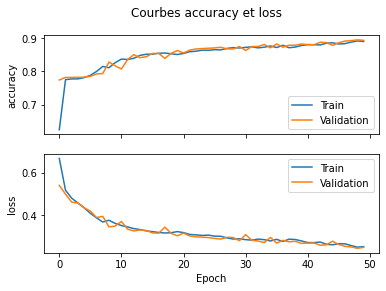

In [ ]:
from keras.callbacks import History
# plotting of loss and accuracy evolution
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Courbes accuracy et loss')
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_ylabel('accuracy')
ax1.legend(['Train', 'Validation'], loc='lower right')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')
fig.show()

Nous obtenons près de 90% d'accuracy pour notre modèle que ce soit sur le train ou la validation.
On observe une stagnation au niveau de l'accuracy et du loss pour notre modèle d'entraînement à partir de 
30 époques, et le modèle atteint des performances de test maximales à la 50e époque. 
Différentes tailles de lots et taux d'apprentissage ont été expérimentés pour entraîner le modèle jusqu'à 
100 époques. La perte d'entraînement diminue mais n'améliore pas les performances de segmentation.
Le modèle est probablement en surentraînement.



### Prédictions du modèle sur le jeu de test et enregistrement des résultats prévus

In [4]:
from keras.models import load_model
import tensorflow as tf
from keras import models, layers, optimizers, backend, metrics, callbacks
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.callbacks import ModelCheckpoint
from PIL import Image

In [ ]:
#%cd("/content/data")

[Errno 2] No such file or directory: '(/content/data)'
/content


In [23]:
#transformation des tif en png
def tif_to_png(directory):
    os.chdir(f"data/{directory}")

    for f in os.listdir():
        if f.endswith("tif"):
            with Image.open(f) as im : # opening images and resaving it to png with PIL
                name, ext = f.split('.')
                name = int(name)
                if name<10 :
                    dest = "00"+str(name)+".png"
                elif (name>=10 and name<100) :
                    dest = "0"+str(name)+".png"
                else :
                    dest = str(name)+".png"
                im.save(dest)

    os.chdir("../..")


def delete_tif(directory):
    
    os.chdir(f"data/{directory}")

    for f in os.listdir():
        if not f.endswith("png"):
            os.remove(f)

    os.chdir("../..")


In [ ]:
tif_to_png(test)
delete_tif(test)

In [16]:
testGene = testGenerator("data/test")
model = unet()
model.load_weights("unet_50.hdf5")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("data/test",results)


C:\Users\utilisateur\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


30/30 [==============================] - 36s 1s/step


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

In [17]:
results = np.round(results,0)
results = results.reshape(results.shape[0:3])

In [18]:
print(results.shape)

(30, 256, 256)


### visualisation des predictions

In [19]:
def show_result_on_an_image(image_number):
    image_test = np.asarray([io.imread("data/test/"+str(image_number)+".png") for img in os.listdir("data/test")], np.uint8)
    plt.figure(figsize=(16,5))

    plt.subplot(131)
    plt.imshow(results[image_number], cmap="gray")
    plt.axis("off")
    plt.title("prediction")

    plt.subplot(132)
    plt.imshow(image_test[image_number], cmap="gray")
    plt.axis("off")
    plt.title("image test")


### Exemple de comparaison entre une image du jeu de test 

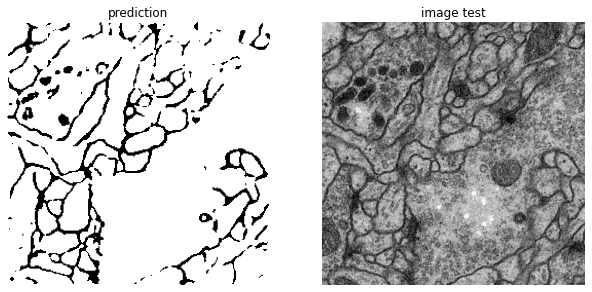

In [21]:
show_result_on_an_image(1)

# Conclusion

L'architecture u-net atteint de très bonnes performances sur des applications de segmentation biomédicale très 
différentes. Grâce à l'augmentation des données avec des déformations élastiques, il ne nécessite que très peu 
d'images annotées et dispose d'un temps d'apprentissage très raisonnable. 
L'architecture u-net peut être appliquée facilement à de nombreuses autres tâches

